In [337]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, widgets
from IPython.display import display
import scipy.linalg
from IPython import display
import pywt
from skimage import data
import skimage
from skimage import data
from skimage import io

# EE290T Homework 4 - Programming Assignment

## Part 1 - Proximal gradient methods for LASSO 

In this assignment, we'll go through the algorithms presented in Ch 8 for Lasso. The Lasso formulation is given by:

$$\min_{\boldsymbol x} \frac{1}{2} \|\boldsymbol y- \boldsymbol A \boldsymbol x\|_2^2 + \lambda \|\boldsymbol x\|_1 $$

Given $\boldsymbol y \in R^m$, $\boldsymbol A\in R^{mxn}$ and $\boldsymbol x \in R^n$ 

__(a)__ Implement Proximal Gradient for Lasso (sometimes called iterative shrinkage thresholding algorithm (ISTA)).  This algorithm is given by: 

__Input:__ $\boldsymbol x_0 \in R^n$ and $L \geq \lambda_{max}(\boldsymbol A^* \boldsymbol A)$ <br>
__while__ $\boldsymbol x_k$ not converged (k=1,2, ...) __do__ <br>
> $\boldsymbol w_k \leftarrow \frac{1}{L}\boldsymbol A^* (\boldsymbol A \boldsymbol x_k -\boldsymbol y)$ <br>
$\boldsymbol x_{k+1} \leftarrow $ soft$(\boldsymbol w_k, \lambda/L)$ 

__end while__ <br>
__Output: $\boldsymbol x_* \leftarrow \boldsymbol x_k$__

In [7]:
def soft_thresh(x, l):
    return np.sign(x) * np.maximum(np.abs(x) - l, 0.)

In [75]:
def ista(x1,L,A,y,lamda,x):
    """ Your code here"""
    x0 = x1
    converge = []
    for i in range(500):
        w = x0 - (1/L)*np.dot(A.T,np.dot(A,x0)-y)
        x01 = soft_thresh(w,lamda/L)
        converge.append(np.linalg.norm(x01-x))
        x0 = x01
    return x0,converge


__(b)__ Now, add the acceleration term and imeplement accelerated proximal gradient method for LASSO (also called FISTA, or fast ISTA).   


__Input:__ $\boldsymbol x_0 \in R^n$, $\boldsymbol p_1 \leftarrow \boldsymbol x_0$, $t_1 \leftarrow 1 $and $L \geq \lambda_{max}(\boldsymbol A^* \boldsymbol A)$ <br>
__while__ $\boldsymbol x_k$ not converged (k=1,2, ...) __do__ <br>
> $\boldsymbol w_k \leftarrow \boldsymbol p_k -\frac{1}{L} \boldsymbol A^*(\boldsymbol A \boldsymbol p_k -y)$ <br>
$\boldsymbol x_{k+1} \leftarrow $ soft$(\boldsymbol w_k, \lambda/L)$ <br>
$t_{k+1} \leftarrow \frac{1+\sqrt{1+4t_k^2}}{2}; \beta_{k+1} \leftarrow \frac{t_{k}-1}{t_{k+1}}$ <br>
$\boldsymbol p_{k+1} \leftarrow \boldsymbol x_{k+1} + \beta_{k+1} (\boldsymbol x_{k+1} - \boldsymbol x_k)$


__end while__ <br>
__Output: $\boldsymbol x_* \leftarrow \boldsymbol x_k$__

In [104]:
def fista(x1,L,A,y,lamda,x):
    xk = x1
    pk = xk
    tk = 1
    converge = []
    for i in range(500):
        wk = pk - (1/L)*np.dot(A.T,np.dot(A,pk)-y)
        xk1 = soft_thresh(wk,lamda/L)
        tk1 = (1+np.sqrt(1+4*tk*tk))/2
        bbk = (tk-1)/tk1
        pk1 = xk1 + bbk*(xk1-xk)
        pk = pk1
        xk = xk1
        tk = tk1
        converge.append(np.linalg.norm(xk-x))
    
    """ Your code here"""
    return xk,converge


__(c)__ Implement the Augmented Lagrange Multiplier (ALM) method for basis pursuit based on Algorithm 8.5 in the textbook.  The ALM method is given by:

__Input:__ $\boldsymbol x_0 \in R^n$ and $\beta > 1$ <br>
__while__ $ \{\boldsymbol x_k, \boldsymbol \lambda_k  \}$ not converged (k=1,2, ...) __do__ <br>
> $\boldsymbol x_{k+1} \leftarrow \arg \min \mathcal{L}_{\mu_k} (\boldsymbol x, \boldsymbol \lambda_k) \text{ using APG}$ <br>
$\boldsymbol \lambda_{k+1} \leftarrow  \boldsymbol \lambda_k + \mu_k (\boldsymbol A \boldsymbol x_{k+1} - \boldsymbol y)$ <br>
$ \mu_{k+1} \leftarrow \text{min}\{\beta \mu_k, \mu_{max}\}$

__end while__ <br>
__Output: $\boldsymbol x_* \leftarrow \boldsymbol x_k$__

In [141]:
def fista_alm(x1,L,A,y,lamda,uk,lk):
    xk = x1
    pk = xk
    tk = 1
    converge = []
    for i in range(500):
        wk = pk - (uk/L)*np.dot(A.T,np.dot(A,pk)-y) - (1/L)*np.dot(A.T,lk)
        xk1 = soft_thresh(wk,lamda/L)
        tk1 = (1+np.sqrt(1+4*tk*tk))/2
        bbk = (tk-1)/tk1
        pk1 = xk1 + bbk*(xk1-xk)
        pk = pk1
        xk = xk1
        tk = tk1
#         converge.append(np.linalg.norm(xk-x))
    
    """ Your code here"""
    return xk

def alm(l0,x0,L,beta,A,y,lamda,umax,x):
    xk = x0
#     betak = beta
    uk = 1
    converge = []
    lk = l0
    for i in range(500):
        print(i)
        xk1 = fista_alm(x0,L,A,y,lamda,uk,lk)
        lk1 = lk + uk*(np.dot(A,xk1)-y) 
#         print(umax,beta*uk)
        uk1 = np.min((beta*uk,umax))
#         print(lk1)
#         print(uk1)
        xk = xk1
        uk = uk1
        lk = lk1
        converge.append(np.linalg.norm(xk-x))
    
    """ Your code here"""
    return xk,converge


__(d)__ Using your code for projected subgradient method (previous homework), plot the convergence rates of
projected subgradient method, ISTA, FISTA, and ALM.  

To do this, simulate a signal corrupted by noise: $\boldsymbol y = \boldsymbol A \boldsymbol x + \boldsymbol n$

Given $\boldsymbol y \in R^m$, $\boldsymbol A\in R^{mxn}$ and $\boldsymbol x \in R^n$ 


In [76]:
def sign(x):
    if x > 0:
        return 1
    if x < 0:
        return -1
    else:
        return np.random.uniform(-1,1)
def sign_v(x):
    x_p = x.copy()
#     print(x.size)
    for j in range(x.size):
        x_p[j] = sign(x[j])
    return x_p
def projected_gradient_descent(A,y,iteration,x):
    """ Your code here"""
    At = np.dot(A.T,np.linalg.inv(np.dot(A,A.T)))
    Atau = np.dot(At,A)
    Tau = np.identity(A.shape[1]) - Atau
    x_hat = np.dot(At,y)
    x0 = np.zeros(x_hat.shape)
    t = 0
    converge = []
    for i in range(iteration):
#         print(i)
        t = t+1
        x01 = x_hat + np.dot(Tau,(x0-(1/t)*sign_v(x0)))
        converge.append(np.linalg.norm(x01-x))
        x0 = x01
#         x_all.append(x0)
    return x0,converge

In [493]:
n = 32             # image height/width
N = n**2           # flat image
#     m = N              # number of measurements 
m = 300
k = 50            # number of non-zero entries in the image

# Create image x
x = np.concatenate((np.random.rand(k),np.zeros(N-k))) # Create sparse vector 
x = x[np.random.permutation(N)];


A = np.random.randint(2, size=(m,N))  # Create measurement matrix, A
A[A==0]=-1

y = A.dot(x)+0.01*np.random.normal(size=y.shape)  # y=Ax

ValueError: operands could not be broadcast together with shapes (300,) (100,100) 

In [87]:
AtA = np.matmul(A.T,A)
e = np.linalg.eig(AtA)
L  = np.max(abs(e[0]))

In [88]:
print(L)

2436.766293893759


In [114]:
"""Your code here"""

x_ista = ista(A=A,L=L,lamda=10,x1=np.zeros(x.shape),y=y,x=x)
x_pgd = projected_gradient_descent(A = A,y=y,iteration=500,x=x)
x_fista = fista(A=A,L=L,lamda=1,x1=np.zeros(x.shape),y=y,x=x)



In [142]:
x_alm =  alm(np.zeros(y.shape),np.zeros(x.shape),L,1,A,y,10,3,x)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [144]:
x_alm[0]

array([-0.        ,  0.        , -0.        , ...,  0.39480229,
        0.        ,  0.        ])

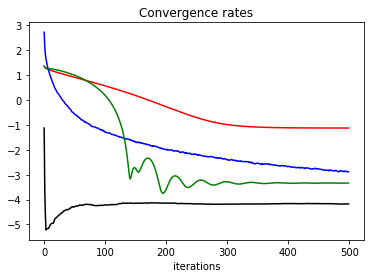

In [147]:
#log
# plt.ylim([0,5])
plt.plot(np.log(x_ista[1]),color = 'r', linestyle='-')
plt.plot(np.log(x_pgd[1]),color = 'b', linestyle='-')
plt.plot(np.log(x_fista[1]),color = 'g',linestyle = '-')
plt.plot(np.log(x_alm[1]),color = 'k',linestyle = '-')
# plt.ylim([0,5])
# plt.plot(x_ista[1],color = 'r', linestyle='-')
# plt.plot(x_pgd[1],color = 'b', linestyle='-')
# plt.plot(x_fista[1],color = 'g',linestyle = '-')
# plt.plot(x_alm[1],color = 'k',linestyle = '-')

plt.title('Convergence rates');
plt.xlabel('iterations');

In [70]:
import sigpy.plot as pl

__(d)__ Does this match your expectation? What are the pros/cons of these methods?

In general, the results match my expectation, Fista converge faster than Ista, and ALM turns to be the best but the slowest.

__(Bonus)__ Use ISTA/FISTA/or ALM to solve a problem of your choice!  

In [220]:
img = io.imread('pikachu.jpg', as_grey=True) 
img = -img +1
# img = img[-1:0:-1,:]

In [185]:
import cv2

In [221]:
imm = cv2.resize(img,(60,80))

In [200]:
print(np.mean(imm))

0.042492412767768675


In [223]:
"""Your code here"""
""" Your Code Here """           # image height/width
N = 80*60          # flat image
m = int(N*0.5)      # number of measurements 

x = imm.flatten()
# x = x/np.max(x)
A = np.random.randint(2, size=(m,N))  # Create measurement matrix, A
A[A==0]=-1

y = A.dot(x)  # y=Ax
x_adj = A.T.dot(y)

AtA = np.matmul(A.T,A)
e = np.linalg.eig(AtA)
L  = np.max(abs(e[0]))

In [228]:
im_fista = fista(A=A,L=L,lamda=1,x1=np.zeros(x.shape),y=y,x=x)

In [235]:
im_ista = ista(A=A,L=L,lamda=1,x1=np.zeros(x.shape),y=y,x=x)

In [208]:
x.shape

(4800,)

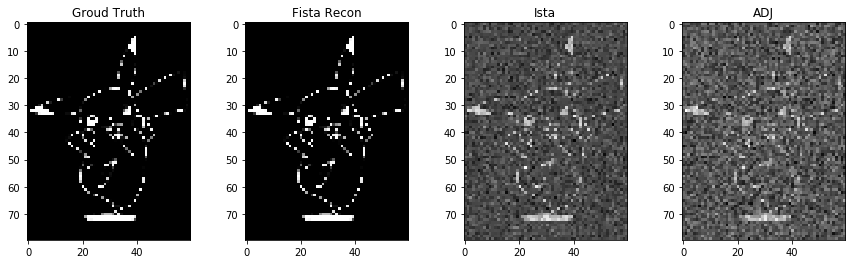

In [239]:
plt.figure(figsize=(15, 4));
plt.subplot(1,4,1),plt.imshow(x.reshape((80,60)),cmap = 'gray');plt.title("Groud Truth");
plt.subplot(1,4,2),plt.imshow(im_fista[0].reshape((80,60)),cmap = 'gray');plt.title("Fista Recon")
plt.subplot(1,4,3),plt.imshow(im_ista[0].reshape((80,60)),cmap = 'gray');plt.title("Ista")
plt.subplot(1,4,4),plt.imshow(x_adj.reshape((80,60)),cmap = 'gray');plt.title("ADJ")
plt.plot(); 

__Bonus Problem__: Here, we try to use different methods on image reconstruction, the results turns to be reasonable. Fista shows the best performance in the comparason.

In [259]:
def wavMask(dims, scale):
    sx, sy = dims
    res = np.ones(dims)
    NM = np.round(np.log2(dims))
    for n in range(int(np.min(NM)-scale+2)//2):
        res[:int(np.round(2**(NM[0]-n))), :int(np.round(2**(NM[1]-n)))] = \
            res[:int(np.round(2**(NM[0]-n))), :int(np.round(2**(NM[1]-n)))]/2
    return res


def imshowWAV(Wim, scale=1):
    plt.imshow(np.abs(Wim)*wavMask(Wim.shape, scale), cmap = plt.get_cmap('gray'))

    
def coeffs2img(LL, coeffs):
    LH, HL, HH = coeffs
    return np.vstack((np.hstack((LL, LH)), np.hstack((HL, HH))))


def unstack_coeffs(Wim):
        L1, L2  = np.hsplit(Wim, 2) 
        LL, HL = np.vsplit(L1, 2)
        LH, HH = np.vsplit(L2, 2)
        return LL, [LH, HL, HH]

    
def img2coeffs(Wim, levels=3):
    LL, c = unstack_coeffs(Wim)
    coeffs = [c]
    for i in range(levels-1):
        LL, c = unstack_coeffs(LL)
        coeffs.insert(0,c)
    coeffs.insert(0, LL)
    return coeffs
    
    
def dwt2(im):
    coeffs = pywt.wavedec2(im, wavelet='db4', mode='per', level=3)
    Wim, rest = coeffs[0], coeffs[1:]
    for levels in rest:
        Wim = coeffs2img(Wim, levels)
    return Wim


def idwt2(Wim):
    coeffs = img2coeffs(Wim, levels=3)
    return pywt.waverec2(coeffs, wavelet='db4', mode='per')

## Part 3 - ADMM for MRI

In this section, you'll implement ADMM for MRI based on chapter 11.  

__(a)__ Implement ADMM for MRI with wavelet and gradient sparsity (equation 11.4.10).  


__while__ $\boldsymbol x_k$ not converged (k=1,2, ...) __do__ <br>
>$\boldsymbol x^{(k+1)} \leftarrow \arg \min_x g_1(\boldsymbol z^{(k)}, \boldsymbol x, \boldsymbol \lambda_1^{(k)})$<br>
$\boldsymbol v^{(k+1)} \leftarrow \arg \min_{v_i} g_2(\boldsymbol z^{(k)}, \boldsymbol v_i, \boldsymbol \lambda_2^{(k)})$<br>
$\boldsymbol z^{(k+1)} \leftarrow \arg \min_{z} L(\boldsymbol z, \boldsymbol x^{(k+1)}, \boldsymbol v^{(k+1)}, \boldsymbol \lambda_1^{(k)}, \lambda_2^{(k)})$<br>
$\boldsymbol \lambda_1^{(k+1)} \leftarrow \boldsymbol \lambda_1^{(k)} + \mu_1(\boldsymbol x^{(k+1)}- \Phi \boldsymbol z^{(k+1)})$ <br>
$\boldsymbol \lambda_2^{(k+1)} \leftarrow \boldsymbol \lambda_2^{(k)} + \mu_2(\boldsymbol v^{(k+1)}- \boldsymbol \nabla \boldsymbol z^{(k+1)})$

__end while__ <br>
__Output: $\boldsymbol x_* \leftarrow \boldsymbol x_k$__

While this looks complicated, all the subproblems have relatively straight forward solutions:  

__while__ $\boldsymbol x_k$ not converged (k=1,2, ...) __do__ <br>
>$\boldsymbol x^{(k+1)} \leftarrow S(\Phi \boldsymbol z^{(k)} -  \frac{ \boldsymbol \lambda_1^{(k)}}{\mu _1}, \frac{\alpha}{\mu_1})$<br>
$\boldsymbol v^{(k+1)}_i \leftarrow S_2((\nabla \boldsymbol z^{(k)})_i -  \frac{(\boldsymbol \lambda_2^{(k)})_i}{\mu_2}, \frac{\beta}{\mu_2})$<br>
$\boldsymbol z^{(k+1)} \leftarrow M^{-1}\boldsymbol b$<br>
$\boldsymbol \lambda_1^{(k+1)} \leftarrow \boldsymbol \lambda_1^{(k)} + \mu_1(\boldsymbol x^{(k+1)}- \phi \boldsymbol z^{(k+1)})$ <br>
$\boldsymbol \lambda_2^{(k+1)} \leftarrow \boldsymbol \lambda_2^{(k)} + \mu_2(\boldsymbol v^{(k+1)}- \boldsymbol \nabla \boldsymbol z^{(k+1)})$

__end while__ <br>
__Output: $\boldsymbol x_* \leftarrow \boldsymbol x_k$__

In [246]:
a = 1+1j

In [251]:
abs(a)*np.exp(1j*np.angle(a))

(1.0000000000000002+1j)

In [252]:
def soft_thresh_complex(x, l):
    return np.sign(abs(x)) * np.maximum(np.abs(x) - l, 0.)*np.exp(1j*np.angle(x))

In [257]:
a = np.array([[1,2,3],[-3,-5,-10],[2,3,-10]])
b = soft_thresh_complex(a,1)
print(b)

[[ 0.+0.00000000e+00j  1.+0.00000000e+00j  2.+0.00000000e+00j]
 [-2.+2.44929360e-16j -4.+4.89858720e-16j -9.+1.10218212e-15j]
 [ 1.+0.00000000e+00j  2.+0.00000000e+00j -9.+1.10218212e-15j]]


In [312]:
B = dwt2(A)

In [322]:
F = scipy.linalg.dft(100)

In [280]:
def tv(n):
    A = np.roll(np.eye(n),1)
    A[0,0] = 0
    A[n-1,0] = 1
    A = np.eye(n) - A
    return A

In [387]:
print(tv(4))

[[ 1. -1.  0.  0.]
 [ 0.  1. -1.  0.]
 [ 0.  0.  1. -1.]
 [-1.  0.  0.  1.]]


In [478]:
def Mfun(Mask,V,z,u1,u2):
    # M*z
    M = ifft2c(Mask*fft2c(z)) + u2*V.T.dot(V.dot(z)) + u1*z
    return M

def gd_update(Mask,V,b,Iter,u1,u2):
    x = b
    for i in range(Iter):
        tmp = Mfun(Mask,V,x,u1,u2)-b
        grad = Mfun(Mask,V,tmp,u1,u2)
        x = x-.1*grad
        print(np.linalg.norm(tmp)/np.linalg.norm(x))
    return x

In [481]:
def admm(y,Mask,u1,u2,alpha,beta):
    F = scipy.linalg.dft(y.shape[0])
    FT = F.T
    zk = np.zeros(y.shape,dtype=np.complex64)
    xk = np.zeros(y.shape,dtype=np.complex64)
    l1 = np.zeros(y.shape,dtype=np.complex64)
    l2 = np.zeros(y.shape,dtype=np.complex64)
    V = tv(y.shape[0])
    I = np.eye(y.shape[0])
    for i in range(10):
        print(i)
#         print(l1)
        xk1 = soft_thresh_complex(dwt2(zk)-l1/u1,alpha/u1)
        vk1 = soft_thresh_complex(V.dot(zk)-l2/u2,beta/u2)
        yy = ifft2c(Mask*y)+idwt2(l1+u1*xk1)+V.T.dot(u2*vk1+l2)
        # M = I + u1*I + u2*V.T.dot(V) 
        zk1 = gd_update(Mask,V,yy,40,u1,u2)
#         zk1 = np.dot(np.linalg.inv(M),yy)
        l1k = l1 + u1*(xk1-dwt2(zk1))
        l2k = l2 + u2*(vk1 - V.dot(zk1))
        zk = zk1
        l1 = l1k
        l2 = l2k
        vk = vk1
        xk = xk1
    return zk
        
    """Your code here"""

__(b)__ Use your code to reconstruct the brain images using the subsampled fourier measurments defined below (M1 and M2).  (For more info on MRI, see Discussion 2 materials).

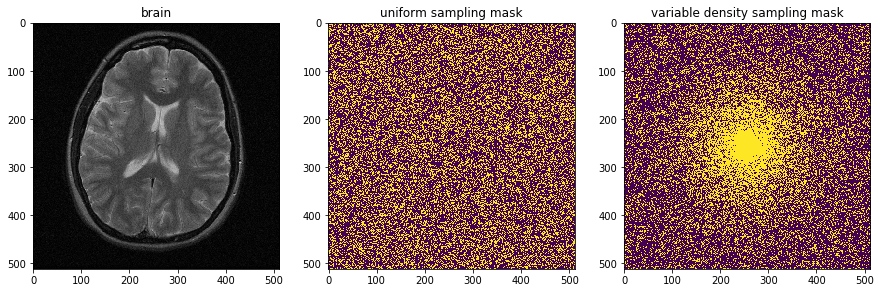

In [242]:
data = np.load('brain.npz')
im, mask_unif, mask_vardens, pdf_unif, pdf_vardens = \
data['im'], data['mask_unif'], data['mask_vardens'], data['pdf_unif'], data['pdf_vardens'],

plt.figure(figsize=(15, 8));
plt.subplot(1,3,1)
plt.imshow(np.abs(im), cmap = 'gray'); plt.title('brain');
plt.subplot(1,3,2)
plt.imshow(mask_unif); plt.title('uniform sampling mask');
plt.subplot(1,3,3)
plt.imshow(mask_vardens); plt.title('variable density sampling mask');

/home/kewang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/home/kewang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


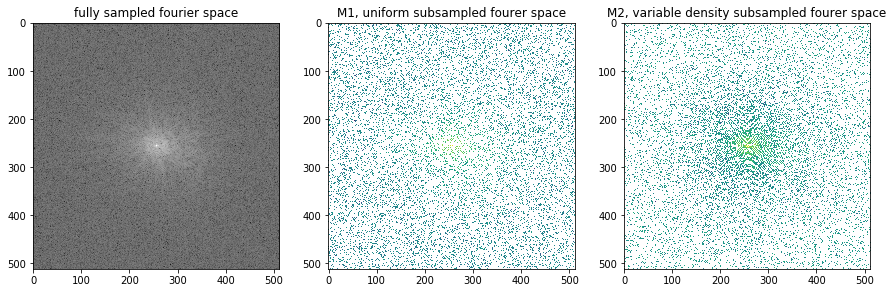

In [326]:
def fft2c(x):
    return 1 / np.sqrt(np.prod(x.shape)) * np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(x)))

def ifft2c(y):
    return np.sqrt(np.prod(y.shape)) * np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(y)))

M = fft2c(im);
M1 = (M * mask_unif)/ pdf_unif;
M2 = (M * mask_vardens)/ pdf_vardens;

plt.figure(figsize=(15, 8));
plt.subplot(1,3,1)
plt.imshow(np.log(np.abs(M)), cmap = 'gray'); plt.title('fully sampled fourier space');
plt.subplot(1,3,2)
plt.imshow(np.log(np.abs(M1*(M1>0)))); plt.title('M1, uniform subsampled fourer space');
plt.subplot(1,3,3)
plt.imshow(np.log(np.abs(M2*(M2>0)))); plt.title('M2, variable density subsampled fourer space');

In [485]:
im_admm = admm(y=M2,Mask = mask_vardens,u1=.1,u2 = .1,alpha=0.05,beta=0.05)
# F = scipy.linalg.dft(512)
# im_fft = np.dot(F,M)

0
0.13855984328665547
0.11780445747673887
0.10053350732278223
0.08610540113925225
0.07399878839562514
0.06379263834823058
0.05514812294937781
0.04779287180576076
0.041507720570704516
0.03611582145877221
0.03147385616931522
0.027465042007965703
0.02399362052980327
0.020980543348327375
0.01836010757137127
0.01607733454286531
0.014085924888813503
0.012346657620764463
0.010826130272888552
0.009495760771670183
0.008330990508037239
0.007310642655064583
0.006416400931320593
0.005632382465229629
0.0049447847791393865
0.004341591680168292
0.003812326411101471
0.003347843082029056
0.0029401494026331768
0.0025822552390972553
0.0022680426572619667
0.0019921539800509384
0.0017498950523513483
0.001537151421876381
0.001350315547763914
0.0011862234674499352
0.001042099607055041
0.0009155086261478028
0.0008043133554434362
0.0007066380240535717
1
0.12002388798788328
0.10394130398844971
0.09024586877884552
0.07853658565859269
0.0684880360168952
0.059835796328918285
0.052364298987447405
0.0458969624854761

In [456]:
np.max(abs(fft2c(ifft2c(im))-im))

4.518280359883027e-16

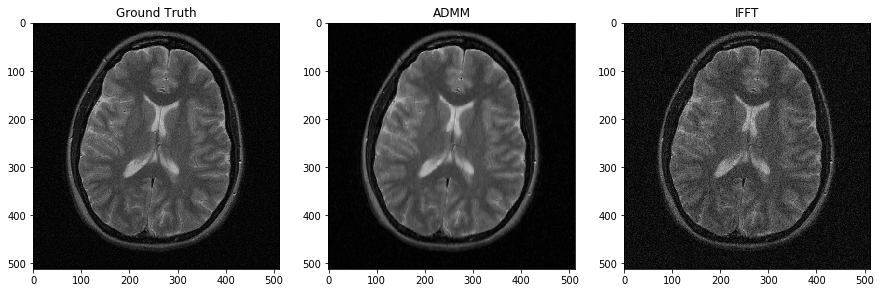

In [492]:
plt.figure(figsize=(15, 8));
plt.subplot(1,3,1)
plt.imshow(np.abs(im), cmap = 'gray');plt.title('Ground Truth');
plt.subplot(1,3,2)
plt.imshow(abs(im_admm),cmap = 'gray'); plt.title('ADMM');
plt.subplot(1,3,3)
plt.imshow(abs(ifft2c(mask_vardens*M2)),cmap = 'gray');plt.title('IFFT');